# Quantitative Analysis of Futures Trading

In this section we examine how to run quantitative analytics on futures and how to build and analyse a simple futures pairs trading strategy. 
We start with looking at the term structure of futures contracts and look at the behaviour of contango and backwardation.
Next, we use our data to construct a back-adjusted continuous time series.
Finally, we use adjusted futures data to research, build and analyse a trading strategy.

This notebook uses the programming language Python and we limit ourselves to the use of basic Python packages to keep our analytics simple and transparent. If you are new to Python, you can find a large amount of tutorial online to get you started.

To begin with, let's import some useful Python packages such as numpy for array calculations, matplotlib for plotting, pandas for time series analysis, and statsmodels for statistical analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller

plt.rcParams['figure.figsize'] = [10, 7]

Once we have imported our packages, we import a file with futures price data using the Pandas read_csv() function. Pandas turns our csv data into a time series that can easily be processed by the other Python packages.

During this process, we tell Pandas to parse the date strings into a datetime object which makes it easier to perform datetime-related arithmetic.

In [2]:
df = pd.read_csv('ES_futures.dat',parse_dates=True,index_col=0)
df.head()

,ESH6,ESM6,ESU6,ESZ6
Date,,,,
2015-10-21,2002.50,1993.0,2002.50,2003.0
2015-10-22,2047.00,2040.0,2017.75,2003.0
2015-10-23,2056.75,2049.5,2050.00,2003.0
2015-10-26,2054.75,2048.0,2050.00,2003.0
2015-10-27,2056.00,2048.5,2031.25,2029.0


Now that we have all the data in our data frame, named df, we can easily plot the different futures contracts.

Note the contract symbols where **ES** stands for the S&P500 E-mini contracts, H, M, U, Z are the expiry months March, June, September and December respectively and 6 denotes the year 2016.

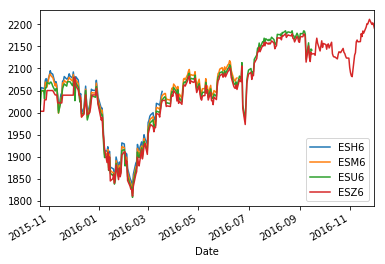

In [3]:
df.plot();

Let's now visualize the term structure, by plotting the prices for each contract at certain points in time. We can see in this chart that the prices for futures tend to get lower the further our expiry is in the future. This phenomenon is called **backwardation**. On the other hand, when prices get higher for longer-dated expiries we call it **contango**. 

The reason for this is that prices include the cost of holding the underlying commodity. For example, if we buy a futures contract for crude oil expiring one year from now, someone else has to store that oil and pay for storage, which is reflected in this price of the future. For ES on the other hand, holding cash rather than the underlying means that you are getting paid interest which is discounted in the futures price.

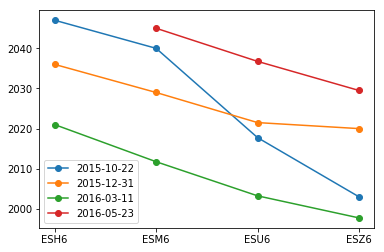

In [4]:
for i in [1,50,100,150]:
    plt.plot(df.iloc[i],'-o',label=df.index[i].date())
    plt.legend(loc='best')

The problem with longer-dated futures contracts is that while they display a price, they are usually a lot less liquid than the shorter-dated contracts. So, in order to devise a meaningful trading strategy we normally consider trading the front months only. However, this becomes problematic since upon expiry we have to close our previous contract and open the next one, which is also called a **roll**. 

Stitching front-month contracts together is shown the the following code. The outer loop iterates through time and the inner loop iterates through the colums and stops at the closest expiry it can find.

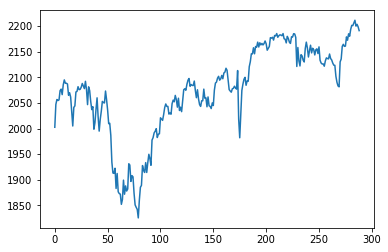

In [5]:
continuous_price = []
for i in range(len(df)):
    for j in df.iloc[i]:
        if ~np.isnan(j):
            continuous_price.append(j)
            break
plt.plot(continuous_price);  

It is clear that simply stitching to contracts together could cause a lot of issues in the quantitative analysis of trading strategies. For example, at the roll we would see an abnormally large return which could badly skew our volatility values. 

When we adjust we go from the most recent prices backwards into the past. Once we encounter a roll, we adjust all the prices prior to this roll by the price difference of the two contracts. In practise, this means that the amount of adjustment increases the further we go into the past. 

To start with, we create a function that, whenever a roll is encountered, it corrects the adjusted price series (**adj_pr**) by the difference (**adj_val**) of the old and new contract in the different contract columns (**contract_col**). 

In [6]:
def adjust_price(adj_pr,df,i,contract_col):
    adj_val = df.iloc[i-1][contract_col]-df.iloc[i-1][contract_col-1]
    return [x+adj_val for x in adj_pr]

Now, we are using the same nested loop structure as we did for the unadjusted continuous front-month series above and apply the adjustment function any time we switch column, detected by the expression **"if not prev_k==k:"**.

For better visualisation we add a vertical line plot for the roll points and record all dates in a list.

We can see in the plot the divergence of unadjusted and adjusted contracts the further we go back into the past and identical values for the most recent data.

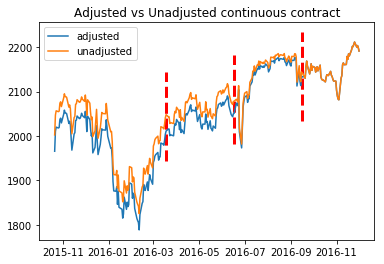

In [7]:
adj_continuous_price = []
prev_k = 0
dates = []

# Double loop as before
for i in range(len(df)):
    for k,j in enumerate(df.iloc[i]):
        if ~np.isnan(j):
            
            # Contract switch detect
            if not prev_k==k:
                
                # Backward price adjust
                adj_continuous_price = adjust_price(adj_continuous_price,df,i,k)
                
                # Vertical line plot
                plt.plot([df.index[i-1]]*2,[j-100,j+100],'r--',lw=3)
                
            adj_continuous_price.append(j)
            
            # record dates for plotting
            dates.append(df.index[i])
            prev_k = k
            break

plt.plot(dates,adj_continuous_price,label='adjusted');
plt.plot(dates,continuous_price,label='unadjusted');
plt.legend()
plt.title('Adjusted vs Unadjusted continuous contract');

By subtracting the unadjusted and adjusted prices from each other we can see the compounded size of the adjustments. In this plot, the steps correlate with the dashed red lines from the previous plot. 

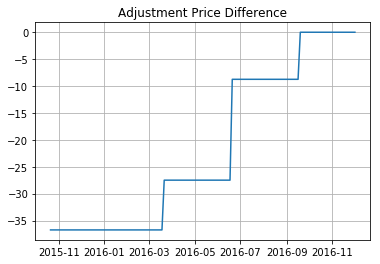

In [8]:
plt.plot(dates,np.array(adj_continuous_price)-np.array(continuous_price));
plt.grid()
plt.title('Adjustment Price Difference');

## Building a Futures Pairs Trading Strategy

Let's now examine a possible futures trading strategy based on the pair Crude Oil (CL) ad RBOB gasoline (XB).
Our underlying economic rationale is that the prices of the two products are strongly dependent on each other and evolve in a similar fashion. As a result, the difference between the prices of the two contracts should oscillate around an average value. If this is the case, the value of our portfolio is somewhat predictable. Namely, when the portfolio moves far away from its average price, we expect it to revert back at some point. We call that **mean reversion**.

In order to get a realistic backtest we need to consider that the futures prices displayed by the exchange do not represent the actual dollar value. Not taking this into consideration could incur significant losses. Looking at the website of the CME we find that the tick price for crude is 10 dollars and 4.20 dollars for gasoline. However, we also need to take into consideration that the two have different tick sizes: 0.01 and 0.0001 for crude and gasoline respectively. 

In [9]:
tick_sz_cl = 0.01
tick_pr_cl = 10
tick_sz_xb = 0.0001
tick_pr_xb = 4.2

For the following exercise our prices as well as the associated dates are stored in separate files on a single line separated by commas. 
Note that the format is significantly different from the csv file format that we've used to build our continuous E-mini contract. This is quite common in reality and it is important to understand how to process different file formats effectively.

In order to convert the data into a useful format we first have to open the files and link them to a suitable file indentifier (such fcl and fxb).

In [10]:
"""Download Contiuous Futures Price Data"""
fcl = open('CL_prices_daily_2011-2019.dat','r')
fxb = open('XB_prices_daily_2011-2019.dat','r')
fdt = open('CL_XB_daily_dates.dat','r')

Now that the files are open they can be processed. In our case we only need to read the first line as all our data are contained in it. Once the line is read, it is split at the separating commas. This creates a list of prices. However, the entries of this list are in string format and we use the **map** function to turn those strings into floating point values. The output of **map** needs to be turned into a list to be readable and for convenience we further turn the list into a Numpy array in the same step.

In Python, all this can be done in one single line. Very impressive!

In [11]:
xb = np.array(list(map(float,fxb.readline().split(','))))
cl = np.array(list(map(float,fcl.readline().split(','))))

Next, we need the dates associated with the price data and instead of mapping the float function to our list, as above, we map the date parser to our list of dates. This parser turns date strings into Python datetime object which are easier and faster to process by the interpreter. Finally, we turn our **map** object into a list. In this case we don't need to convert the list into an array as we will not perform any mathematical operations on it.

In [12]:
dt = list(map(parse,fdt.readline().split(',')))

The next step is very important: from our prices we create a balanced portfolio which will hopefully have a mean-reverting behaviour. 

We first perform a linear regression and determine our regression parameters alpha and beta:

$$P_{XB} = \beta*P_{CL}+\alpha$$

Next, we assume that the expected value of our portfolio is 0:

$$E(P_{port}) = \beta*P_{CL}+\alpha - P_{XB} = 0$$

Finally, we need to take into account tick price $T$ and tick size $S$:

$$E(P_{port}) = \beta*P_{CL}*\frac{T_{CL}}{S_{CL}}+\alpha - P_{XB}*\frac{T_{XB}}{S_{XB}} = 0$$


Let's now perform a linear fit and calculate alpha and beta. However, if we were to do this on the whole dataset we could easily be a victim of overfitting. Therefore, we exclude the last 3 years, roughly 750 days, from the data. We can see that our hedge ratio $\beta$ is approximately 0.5. This means that we hedge every long CL contract with 2 short XB contracts and vice versa.

In [13]:
oos = 750
cl_adj = cl*tick_pr_cl/tick_sz_cl
xb_adj = xb*tick_pr_xb/tick_sz_xb
beta,alpha = np.polyfit(cl_adj[:-oos],xb_adj[:-oos],1)
print(beta)

0.5053650780201371


When we visulalize this relationship we can see that our real porfolio value fluctuates around the theoretical regression line and our assumption is that the portfolio will always revert back to this line at some point. 

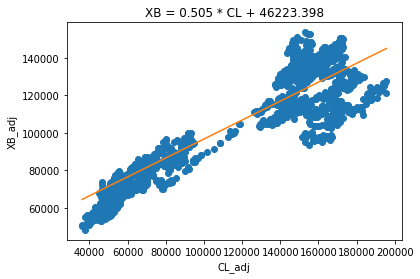

In [14]:
plt.plot(cl_adj,xb_adj,'o')
xx = np.linspace(min(cl_adj),max(cl_adj),100)
yy = np.polyval([beta,alpha],xx)
plt.plot(xx,yy);
plt.xlabel('CL_adj')
plt.ylabel('XB_adj');
plt.title('XB = %.3f * CL + %.3f'%(beta,alpha));

With this we can now plot the value of the portfolio. Note that we excluded the last 3 years from the calculation of our hedge ratio $\beta$. We see that the portfolio value indeed fluctuates around zero with a variable amplitude and this is also true for the latest 3 years of our data which were not taken into account by the calculation.

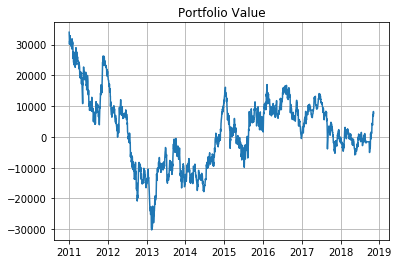

In [15]:
resid = beta*cl_adj+alpha-xb_adj
band = np.std(resid[:-oos])
plt.plot(dt,resid)
plt.grid()
plt.title('Portfolio Value');

Apart from visual inspection, one way to determine if the portfolio value has mean-reverting behaviour is to apply the Augmented Dickey-Fuller (ADF) test. When we run this test, the first value of our output determines the quality of the mean reversion. In our case the value is -3.147. We then look if this value is below the 1%, 5% or 10% critical values. In our case it is below the 5% critical value, which tells us in statistical terms that we "can reject the null-hypothesis that our time series is not mean reverting" with 95% certainty. In simple terms (but not strictly mathematically correct) we could say that we are 95% certain that the mean reversion is legitimate.

In [16]:
out = adfuller(resid)
tstat = out[0]
crit = out[4]
print(tstat, crit)

-3.1469826482629792 {'1%': -3.4335817890636946, '5%': -2.8629676404673794, '10%': -2.5675300130680228}


## Building a backtest

We can now build a backtest of a trading strategy based on our research. In this strategy we will always trade the 1:2 spread of CL/XB. However, when the value of our spread portfolio is below the mean we go long CL and short XB, while above the mean, we reverse both trade directions. We call this "long the spread" and "short the spread" respectively, even though we actually have long and short positions both times. 
In addition, we increase our position size the further we move away from the mean, as we have a higher certainty that our spread will revert back. 
To start with, we first determine the parameters of our strategy. LEVELS is the maximum number of positions we are allowed to enter as we move further away from the mean. In theory, we could make this number very high but this also means that we take almost unlimited risk as there is always a non-zero probability our spread will never revert. This could, for example be a result of insider trading or the introduction of a new technology.
Secondly, we define the step size with which we increase our positions, our bandwidth. This is usually expressed as a multiple of the standard deviation of our portfolio value. Note that when calculating the standard deviation, we have to avoid the out-of-sample (OOS) data to eliminate look-ahead bias.

In [17]:
LEVELS = 5
bw = band*0.25

In the next step we define some objects that are used in the backtest. **inpos** tells us if we have currently a position on at a given band and **entry** records the entry price for that band.
**pnls** is a list that records the realised pnls for each trade and **dates** collects the associated exit dates. 
Finally, **unrlzd** records the unrealized PnL at each time step, which is the profit we would have made if we exited all the positions at this point. 

In [18]:
inpos = {lvl:0 for lvl in range(1,LEVELS+1)}
entry = {lvl:0 for lvl in range(1,LEVELS+1)}
pnls = []
dates = []
unrlzd = []
lvlpnl = 0

In our backtest we run two loops, one that iterates through every time step **i** and another that iterates through every band. At each iteration we test for 4 conditions long and short entry as well as long and short exit. As we enter a new position, we have to make sure that this particular positions has not yet been filled, likewise on exit we need to make sure that the position at a given band actually exists. For example, we would enter a short spread if our portfolio value goes above band 4, which is one standard deviation above the mean. Likewise, we exit that position if our portfolio value drops below 0.75 standard deviations and so on. 
For each new entry level we recod the trade direction and entry price and upon exit we record the PnL and set our trade direction to zero.

In [19]:
for i in range(len(resid)):
    unrlzd.append(lvlpnl)
    lvlpnl = 0
    for lvl in range(1,LEVELS+1):
        lvlpnl += (resid[i]-resid[i-1])*inpos[lvl]
        
        #"""Short entry condition"""
        if not inpos[lvl] and resid[i]>bw*lvl:
            inpos[lvl]=-1
            entry[lvl] = resid[i]
            
        #"""Short exit condition"""
        elif inpos[lvl]==-1 and resid[i]<bw*(lvl-1):
            pnl = (resid[i]-entry[lvl])*inpos[lvl]
            pnls.append(pnl)
            dates.append(dt[i])
            inpos[lvl] = 0
         
        #"""Long entry condition"""
        elif not inpos[lvl] and resid[i]<-bw*lvl:
            inpos[lvl]=1
            entry[lvl] = resid[i]
            
        #"""Long exit condition"""
        elif inpos[lvl]==1 and resid[i]>-bw*(lvl-1):
            pnl = (resid[i]-entry[lvl])*inpos[lvl]
            pnls.append(pnl)            
            dates.append(dt[i])
            inpos[lvl] = 0

Once we have run the backtest we can now analyse our results. Let's first plot the realised and unrealised PnLs.
We can see that our realised PnLs in blue show a very steady uptrend. However, unrealised PnLs show some significant drawdowns. As we move further away from the mean and enter new positions, the positions which are open already will temporarily go into a drawdown as the price moves strictly against us. This can, at times, be a gut-wrenching experience and only our conviction that the price will revert back to the mean can give us confidence in our strategy. 
The right-hand side of the dashed red line indicates the out-of-sample zone, the area which we did not include in the calculation of $\alpha$, $\beta$ and $\sigma$. We can see that our strategy shows a solid out-of-sample performance, which is an important factor to give us confidence to trade this strategy going forward. 

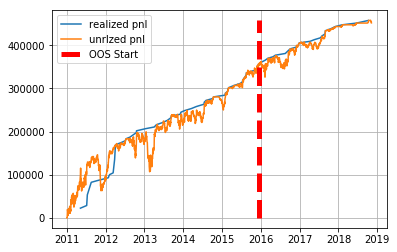

In [22]:
plt.plot(dates,np.cumsum(pnls),'-',label='realized pnl')
plt.plot(dt,np.cumsum(unrlzd),label='unrlzed pnl')
plt.plot([dt[-oos]]*2,[0,sum(pnls)],'r--',lw=5,label='OOS Start')
plt.grid()
plt.legend();

Finally, we calculate a few metrics to evaluate our strategy. 
- __Profit-per-trade__: we want to make sure that we make significantly more money that we pay in commissions and slippage. 
- __Drawdown__: the biggest maximum drop in rolling performance.
- __Biggest winning/losing day__: what daily performance can we expect.

Note, that profit-per-trade is calculated on the realized PnLs whereas drawdown and biggest winning and losing days use the unrealized PnLs for calculation.
In our simple example here we calculate all our metrics in dollars. It should be mentioned that it is also possible, and in many cases desirable, to calculate metrics in relative/percentage terms.
There are other metrics that can be calculated, for example the Sharpe ratio, longest winning/losing streaks, strategy volatility and many more, which will help you to characterise your strategy. 

In [21]:
print('Profit per trade: %.2f'%np.mean(pnls))
print('Max Dollar Drawdown: %.2f'%(pd.DataFrame(unrlzd)-pd.DataFrame(unrlzd).expanding().max()).min().values[0])
print('Biggest Winning/Losing Day: %.2f/%.2f'%(max(unrlzd),min(unrlzd)))

Profit per trade: 6180.75
Max Dollar Drawdown: -39207.51
Biggest Winning/Losing Day: 22152.10/-20582.56
